# Pointer Network Attention Demo

The below code trains a [pointer network](https://arxiv.org/abs/1506.03134) like architecture that takes as input a sequence of vectors and outputs the vector with the minimum or maximum value along a particular coordinate. In other words, a neural network version of argmax/argmin.

### Setup

Let $\{\mathbf{c}_i\}_{i=1}^n = (\mathbf{c}_1, \ldots, \mathbf{c}_n)$ be a sequence of $n$ vectors with each $\mathbf{c}_i \in \mathbb{R}^d$. The minimum and maximum target positions, $i_\min$ and $i_\max$, for the sequence are given by

$$
\begin{align*}
    i_\min &= \text{argmin}_i \left\{ x_{i, k_\min}\right\} \\
    i_\max &= \text{argmax}_i \left\{ x_{i, k_\max}\right\} \\
\end{align*}
$$

where $1 \leq k_\min \neq k_\max \leq d$ are a priori chosen coordiantes along which to compute the minimum or maximum.

### Model

The model has the following form

$$
\begin{align*}
    \mathbf{u}_i &= A \mathbf{c}_i & \; i = 1, \ldots, n \\
    \mathbf{v} &= B \mathbf{q} \\
    \mathbf{p} &= \text{softmax}_i(\mathbf{v}^T \mathbf{u}_i) \\
    \mathbf{z} &= \sum_i p_i \mathbf{c}_i
\end{align*}
$$

where $A, B \in \mathbb{R}^{p \times d}$ and $\mathbf{q} \in \{\mathbf{q}_\min, \mathbf{q}_\max\} \subseteq \mathbb{R}^d$ is a query vector indicating whether the model should output the minimum or maximum.

The loss is defined as the mean squared error between the output and target vector.

$$
\begin{align*}
    l &= \frac{1}{n}\sum_j (z_j - c_{t,j})^2
\end{align*}
$$

where $t$ is either $i_\min$ or $i_\max$.

### Details
The vectors $\mathbf{q}_\min$ and $\mathbf{q}_\max$ are initialized to random values sampled from $N(\mathbb{0}, \mathbb{I}_d)$ and held constant throughout training. The code below uses 10 dimensional context and query vectors and 7 dimensional hidden representations. The model is optimized over 1,600 training instances using RMSProp with mini batches of size 8. Each training instance contains betwen 5 and 14 context vectors. To better assess generalization validation instances are longer, containing between 15 and 24 context vectors.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch import FloatTensor
from torch.autograd import Variable
from torch.nn import Linear, Module

from attention import attend


seed = sum(map(ord, 'les bons mots'))
np.random.seed(seed)
torch.manual_seed(seed)


def Volatile(x):
    return Variable(x, volatile=True)

In [2]:
class Data(object):
    dim = 10
    min_position, max_position = 3, 7
    q_min = np.random.normal(0, 1, dim).astype(np.float32)
    q_max = np.random.normal(0, 1, dim).astype(np.float32)
    query = np.row_stack([q_min, q_max])

    @staticmethod
    def create_minibatches(n, m, min_length, max_length):
        assert 0 < min_length <= max_length

        minibatches = []
        for i in range(n):
            lengths = np.random.randint(min_length, max_length + 1, m)
            context = np.zeros((m, lengths.max(), Data.dim), dtype=np.float32)
            target = np.zeros((m, 2, Data.dim))
            target_indices = []

            for j, length in enumerate(lengths):
                c = np.random.normal(0, 1, (length, Data.dim))
                k_min = np.argmin(c[:,Data.min_position])
                k_max = np.argmax(c[:,Data.max_position])
                target_min = c[k_min]
                target_max = c[k_max]
                context[j,:length] = c
                target[j,0] = target_min
                target[j,1] = target_max
                target_indices.append((k_min, k_max))

            query = FloatTensor(np.tile(Data.query, (m, 1, 1)))
            context = FloatTensor(context)
            target = FloatTensor(target)
            minibatches.append((query, context, target, lengths, target_indices))
        return minibatches

In [3]:
class PointerNet(Module):
    def __init__(self, n_hidden):
        super(PointerNet, self).__init__()
        self.n_hidden = n_hidden
        self.f = Linear(Data.dim, n_hidden)
        self.g = Linear(Data.dim, n_hidden)

    def forward(self, q, x, lengths=None, **kwargs):
        batch_size_q, n_queries, dim_q = q.size()
        batch_size_x, n_inputs, dim_x = x.size()
        assert batch_size_q == batch_size_x
        assert dim_q == dim_x
        batch_size = batch_size_q
        dim = dim_q

        q_flat = q.view(batch_size*n_queries, dim)
        u_flat = self.f(q_flat)
        u = u_flat.view(batch_size, n_queries, self.n_hidden)

        x_flat = x.view(batch_size*n_inputs, dim)
        v_flat = self.g(x_flat)
        v = v_flat.view(batch_size, n_inputs, self.n_hidden)

        return attend(u, v, value=x, context_sizes=lengths, **kwargs)

In [4]:
batch_size = 8

n_train = 200
min_length_train, max_length_train = 5, 14
train_batches = Data.create_minibatches(n_train, batch_size, min_length_train, max_length_train)

n_valid = 100
min_length_valid, max_length_valid = 15, 24
valid_batches = Data.create_minibatches(n_valid, batch_size, min_length_valid, max_length_valid)

In [5]:
net = PointerNet(7)
opt = torch.optim.RMSprop(net.parameters(), lr=0.001)
mse = torch.nn.MSELoss()

In [6]:
epoch = 0
max_epochs = 10
while epoch < max_epochs:
    sum_loss = 0
    for query, context, target, lengths, target_indices in train_batches:
        net.zero_grad()
        output = net(Variable(query), Variable(context), lengths=lengths)
        loss = mse(output, Variable(target))
        loss.backward()
        opt.step()
        sum_loss += loss.data[0]
    epoch += 1
    print('[{:2d}] {:5.3f}'.format(epoch, sum_loss / n_train))

[ 1] 0.560
[ 2] 0.237
[ 3] 0.157
[ 4] 0.120
[ 5] 0.099
[ 6] 0.085
[ 7] 0.075
[ 8] 0.068
[ 9] 0.062
[10] 0.058


In [7]:
sum_loss = 0
sum_error_min = 0
sum_error_max = 0
for query, context, target, lengths, target_indices in valid_batches:
    weight, output = net(Volatile(query), Volatile(context), lengths=lengths, return_weight=True)

    loss = mse(output, Volatile(target))
    sum_loss += loss.data[0]

    weight = weight.data.numpy()
    for i, (i_min_true, i_max_true) in enumerate(target_indices):
        w_min, w_max = weight[i]
        i_min_pred = w_min.argmax()
        i_max_pred = w_max.argmax()
        sum_error_min += int(i_min_true != i_min_pred)
        sum_error_max += int(i_max_true != i_max_pred)

print('valid loss: {:5.3f}'.format(sum_loss / n_valid))
print('valid error min: {:5.3f}'.format(sum_error_min / (n_valid * batch_size)))
print('valid error max: {:5.3f}'.format(sum_error_max / (n_valid * batch_size)))

valid loss: 0.066
valid error min: 0.000
valid error max: 0.000


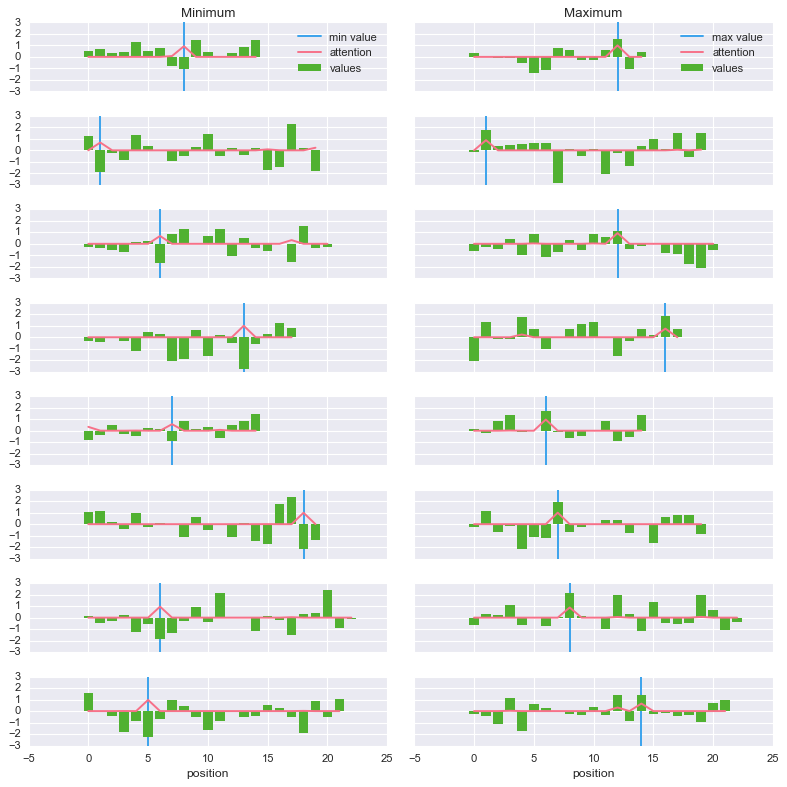

In [8]:
query, context, target, lengths, target_indices = valid_batches[0]
weight, output = net(Volatile(query), Volatile(context), lengths=lengths, return_weight=True)
context = context.numpy()
weight = weight.data.numpy()

colors = sns.color_palette('husl', 3)
fig, axs = plt.subplots(batch_size, 2, figsize=(10, 10), sharex=True, sharey=True)
axs_min, axs_max = axs[:,0], axs[:,1]

for i, (i_min, i_max) in enumerate(target_indices):
    length = lengths[i]
    w_min, w_max = weight[i]
    c_min = [context[i,j,Data.min_position] for j in range(length)]
    c_max = [context[i,j,Data.max_position] for j in range(length)]

    axs_min[i].axvline(i_min, zorder=1, color=colors[2], label='min value')
    axs_min[i].bar(np.arange(length) - 0.4, c_min, zorder=2, color=colors[1], lw=0, label='values')
    axs_min[i].plot(np.arange(length), w_min[:length], zorder=3, color=colors[0], label='attention')

    axs_max[i].axvline(i_max, zorder=1, color=colors[2], label='max value')
    axs_max[i].bar(np.arange(length) - 0.4, c_max, zorder=2, color=colors[1], lw=0, label='values')
    axs_max[i].plot(np.arange(length), w_max[:length], zorder=3, color=colors[0], label='attention')

axs_min[0].set_title('Minimum')
axs_max[0].set_title('Maximum')
axs_max[0].legend(loc='best')    
axs_min[0].legend(loc='best')
axs_max[0].legend(loc='best')
axs_min[-1].set_xlabel('position')
axs_max[-1].set_xlabel('position')
plt.tight_layout()